# Lab | Unsupervised learning intro

#### Instructions 


It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the `Spotify` API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

1. Check whether or not the song is in the Billboard Hot 200.
2. Collect the audio features from the `Spotify` API.

After that, you want to send the `Spotify` audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

## First step is getting the top 200 songs from billboard into a pandas df

In [39]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


url = "https://www.billboard.com/charts/billboard-200"


get = requests.get(url)
get.status_code

200

In [40]:
soup = BeautifulSoup(get.content, "html.parser")

In [41]:
# song titles
song_titles = soup.find_all("span", class_="chart-element__information__song text--truncate color--primary")

# artists
artists = soup.find_all("span", class_="chart-element__information__artist text--truncate color--secondary")

# last week
last_week_ranks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--last")

# peak rank
peak_ranks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--peak")

# weeks on chart
weeks_on_chart = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--week")


In [4]:
def text_getter(list_of_html_elements):
    for element in list_of_html_elements:
        for datapoint in range(len(element)):
            element[datapoint] = element[datapoint].get_text()
    return(list_of_html_elements)
    

In [42]:
lsts = [song_titles, artists, last_week_ranks, peak_ranks, weeks_on_chart]

In [43]:
text_getter(lsts)

[["Fearless (Taylor's Version)",
  'Certified Lover Boy',
  'Expensive Pain',
  'Sincerely, Kentrell',
  'Montero',
  'Sour',
  'Planet Her',
  'Love For Sale',
  'Dangerous: The Double Album',
  'Donda',
  'In These Silent Days',
  'F*ck Love',
  'Happier Than Ever',
  'SoulFly',
  'The Highlights',
  'Shoot For The Stars Aim For The Moon',
  'What You See Is What You Get',
  'My Turn',
  'Future Nostalgia',
  'The Melodic Blue',
  'The Voice Of The Heroes',
  "Hollywood's Bleeding",
  'Legends Never Die',
  'Fine Line',
  "A Gangsta's Pain",
  'La 167',
  'Goodbye & Good Riddance',
  'The Off-Season',
  'Justice',
  'Dreamland',
  'Hall Of Fame',
  "This One's For You",
  'Greatest Hits',
  'Folklore',
  'Trust Fund Babies',
  'Hamilton: An American Musical',
  'Trip At Knight',
  'Star-Crossed',
  'Country Stuff (EP)',
  'Curtain Call: The Hits',
  'Jose',
  'If I Know Me',
  'Rumours',
  'Over It',
  'Tickets To My Downfall',
  'Chronicle The 20 Greatest Hits',
  'Diamonds',
  'Met

In [79]:
billboard_top200 = pd.DataFrame(
    {"song_titles": song_titles,
     "artist": artists,
     "last_week_rank": last_week_ranks,
     "peak_rank": peak_ranks,
     "weeks_on_chart": weeks_on_chart}
)

In [80]:
# now we have the top 200 songs from billboard

billboard_top200

,song_titles,artist,last_week_rank,peak_rank,weeks_on_chart
0,Fearless (Taylor's Version),Taylor Swift,157,1,25
1,Certified Lover Boy,Drake,2,1,5
2,Expensive Pain,Meek Mill,-,3,1
3,"Sincerely, Kentrell",YoungBoy Never Broke Again,1,1,2
4,Montero,Lil Nas X,3,2,3
...,...,...,...,...,...
195,Die A Legend,Polo G,193,6,120
196,Ghetto Gospel,Rod Wave,194,10,87
197,Hozier,Hozier,200,2,220
198,Greatest Hits So Far...,Zac Brown Band,-,20,324


## Next step is applying k-means clustering to a playlist of 5000 songs from spotify

In [12]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="da55f67d57504befa94a4c8a982c7f77",
                                                           client_secret="3b08e6c5c38744eeb726342990f814bc"))

In [13]:
# function from last lab to save the songs and features from a spotify playlist in a pandas df

def playlist_df(playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df

    results = sp.user_playlist_tracks("spotify", playlist_id)
    tracks = results['items']

    for oset in range(100,results['total'],100):
        results = sp.user_playlist_tracks("spotify", playlist_id, offset=oset)
        tracks += results['items']

   
    for track in tracks:
            # Create empty dict
        playlist_features = {}
            # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
            
            # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [22]:
# this is a playlist from spotify with 5000 songs

playlist = playlist_df("4rnleEAOdmFAbRcNCgZMpY")
playlist 

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Hozier,Hozier (Deluxe),Take Me To Church,7dS5EaCoMnN7DzlpT6aRn2,0.566,0.664,4,-5.303,0,0.0464,0,0.116,0.437,128.945,241688,4
1,Mike Posner,31 Minutes to Takeoff,Cooler Than Me - Single Mix,2V4bv1fNWfTcyRJKmej6Sj,0.768,0.820,7,-4.630,0,0.0474,0,0.689,0.625,129.965,213293,4
2,"Tyler, The Creator",Flower Boy,See You Again (feat. Kali Uchis),7KA4W4McWYRpgf0fWsJZWB,0.558,0.559,6,-9.222,1,0.0959,0.000007,0.109,0.620,78.558,180387,4
3,Bastille,Bad Blood,Pompeii,3gbBpTdY8lnQwqxNCcf795,0.679,0.715,9,-6.383,1,0.0407,0,0.271,0.571,127.435,214148,4
4,Shakira,"Oral Fixation, Vol. 2 (Expanded Edition)",Hips Don't Lie (feat. Wyclef Jean),3ZFTkvIE7kyPt6Nu3PEa7V,0.778,0.824,10,-5.892,0,0.0707,0,0.405,0.758,100.024,218093,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290,MARINA,The Family Jewels,Hermit the Frog,4Zcz6saEkOII3PlXd9gN3o,0.609,0.679,0,-4.545,1,0.0312,0,0.199,0.487,122.034,215960,4
5291,Olivia Rodrigo,deja vu,deja vu,61KpQadow081I2AsbeLcsb,0.439,0.610,9,-7.236,1,0.1160,0.000011,0.341,0.172,181.088,215508,4
5292,BIA,FOR CERTAIN,WHOLE LOTTA MONEY,5yorXJWdBan1Vlh116ZtQ7,0.897,0.371,1,-5.019,1,0.3680,0,0.325,0.441,81.008,156005,4
5293,Ashnikko,DEMIDEVIL,Slumber Party (feat. Princess Nokia),11ZulcYY4lowvcQm4oe3VJ,0.964,0.398,11,-8.981,0,0.0795,0.000039,0.101,0.563,105.012,178405,4


In [23]:
playlist_copy = playlist.copy()

In [24]:
# check data types in case we need to convert objects to numeric form

playlist_copy.dtypes

artist               object
album                object
track_name           object
track_id             object
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
instrumentalness     object
liveness            float64
valence             float64
tempo               float64
duration_ms          object
time_signature       object
dtype: object

In [27]:
# these columns should be numeric

playlist_copy[["instrumentalness", "duration_ms", "time_signature", "key", "mode"]] = playlist_copy[["instrumentalness", "duration_ms", "time_signature", "key", "mode"]].convert_dtypes(convert_integer=True, convert_floating=True)

In [28]:
playlist_copy.dtypes

artist               object
album                object
track_name           object
track_id             object
danceability        float64
energy              float64
key                   Int64
loudness            float64
mode                  Int64
speechiness         float64
instrumentalness    Float64
liveness            float64
valence             float64
tempo               float64
duration_ms           Int64
time_signature        Int64
dtype: object

In [32]:
# drop unnecessary columns

playlist_final_data = playlist_copy.drop(columns=["artist", "album", "track_name"])

# set track_id to index so we can avoid creating 5000 new columns when encoding

playlist_final_data = playlist_final_data.set_index("track_id")

In [33]:
# encode the categoricals 

X_encoded = pd.get_dummies(playlist_final_data)
X_encoded

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
track_id,,,,,,,,,,,,
7dS5EaCoMnN7DzlpT6aRn2,0.566,0.664,4,-5.303,0,0.0464,0.0,0.116,0.437,128.945,241688,4
2V4bv1fNWfTcyRJKmej6Sj,0.768,0.820,7,-4.630,0,0.0474,0.0,0.689,0.625,129.965,213293,4
7KA4W4McWYRpgf0fWsJZWB,0.558,0.559,6,-9.222,1,0.0959,0.000007,0.109,0.620,78.558,180387,4
3gbBpTdY8lnQwqxNCcf795,0.679,0.715,9,-6.383,1,0.0407,0.0,0.271,0.571,127.435,214148,4
3ZFTkvIE7kyPt6Nu3PEa7V,0.778,0.824,10,-5.892,0,0.0707,0.0,0.405,0.758,100.024,218093,4
...,...,...,...,...,...,...,...,...,...,...,...,...
4Zcz6saEkOII3PlXd9gN3o,0.609,0.679,0,-4.545,1,0.0312,0.0,0.199,0.487,122.034,215960,4
61KpQadow081I2AsbeLcsb,0.439,0.610,9,-7.236,1,0.1160,0.000011,0.341,0.172,181.088,215508,4
5yorXJWdBan1Vlh116ZtQ7,0.897,0.371,1,-5.019,1,0.3680,0.0,0.325,0.441,81.008,156005,4


In [123]:
# scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X_encoded)


pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.718544,-0.207045,-0.345950,0.310187,-1.105015,-0.577242,-0.209716,-0.503820,-0.346679,0.253495,0.663296,0.086663
1,0.766934,0.725807,0.479188,0.597167,-1.105015,-0.566902,-0.209716,3.543372,0.477881,0.291899,0.002151,0.086663
2,-0.777375,-0.834927,0.204142,-1.360951,0.904965,-0.065415,-0.209655,-0.553262,0.455951,-1.643605,-0.764027,0.086663
3,0.112441,0.097926,1.029280,-0.150346,0.904965,-0.636180,-0.209716,0.590970,0.241039,0.196643,0.022059,0.086663
4,0.840473,0.749726,1.304326,0.059026,-1.105015,-0.325982,-0.209716,1.537434,1.061214,-0.835398,0.113914,0.086663


In [35]:
# checing for best k

from sklearn.cluster import KMeans
import numpy as np

K = range(2, 20)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

inertia

[56950.51674529068,
 52542.78993542973,
 48695.82637515103,
 45636.16298465676,
 43263.11948139819,
 40449.57505482742,
 38752.27690056512,
 37505.799341575024,
 36292.03239263686,
 35353.271491714884,
 34428.95688856859,
 33583.19119492121,
 32920.156707773865,
 32210.74336583979,
 31575.693233534806,
 31044.625977292744,
 30553.99625456104,
 30037.659089897585]

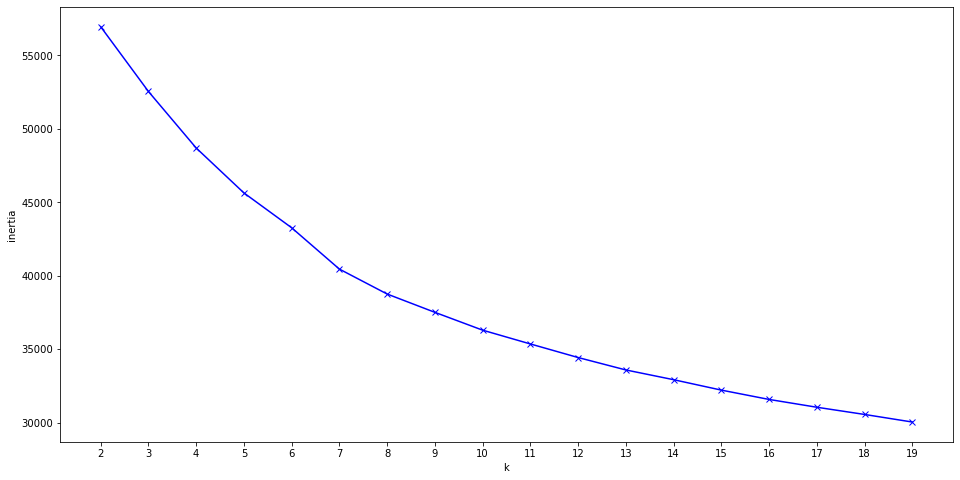

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

In [162]:
# seems like 8 is a good k value to choose

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=42)

In [163]:
clusters = kmeans.predict(X)

pd.Series(clusters).value_counts().sort_index()


0     837
1     148
2    1896
3     790
4     133
5    1491
dtype: int64

## **I have no idea what these different clusters really mean. How can i find out which characteristics each group has? In the end it would only be useful if we know why a song goes into whichever cluster :)**

## Now I will try the whole pipeline

In [154]:
# this function checks if the user inputted song is in the billboard top 200 then returns the track id from spotify

def get_track_id():

    song = input("Choose a song")

    if song in billboard_top200["song_titles"].values:
        query = f'track:{song}'
        results = sp.search(q=query)
    else:
        print("Song not in top 200, please choose again")
    
    id = results['tracks']['items'][0]['id']

    return id

In [134]:
# this function returns a pandas df of the audio features with the irrelavent columns dropped

def get_audio_features(track_id):

    # get the audio features based on the track_id

    audio_features = pd.DataFrame(sp.audio_features(track_id)).set_index("id")

    # drop irrelevant columns

    audio_features = audio_features.drop(columns=["type", "uri", "track_href", "analysis_url", "acousticness"])

    audio_features[["instrumentalness", "duration_ms", "time_signature", "key", "mode"]] = audio_features[["instrumentalness", "duration_ms", "time_signature", "key", "mode"]].convert_dtypes(convert_integer=True, convert_floating=True)
    
    return audio_features

In [142]:
def predict_cluster(song_df):

    # scale features of song (there are no numericals so no need to encode)

    song_scaled = scaler.transform(song_df)

    # predict cluster using kmeans model which we defined above based on the 5000 songs playlist

    cluster = kmeans.predict(song_scaled)
    
    return cluster

In [171]:
# now to try the pipeline
# first pick a song

song = get_track_id()

# then this function returns the audio features from the chosen song

song_df = get_audio_features(song)

# now this function will predict which cluster the song should belong to

predict_cluster(song_df)


array([4], dtype=int32)

## Hard to judge whether the prediction is good because I don't know what the different clusters actually mean :(
